In [78]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import re
import os
import random
import numpy
import glob
import matplotlib
import tifffile

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot
from typing import Any
from skimage import filters

from dataset import TarFLCDataset
from modules.transforms import SimCLRTransform
from main import SimCLR
from backbones import get_backbone
from evaluation import get_dataset
from utils.plotting import savefig

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="green-magenta",
    colors=["tab:green", "#ff00ff"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="gray-purple",
    colors=["#353535", "#aa87de"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

# Use a resnet backbone.
MODEL = "simclr-resnet18-STED"
MODEL = "IMAGENET1K_V1"
# MODEL = "MICRA-Net"
# MODEL = "naive"
# MODEL = "ConvNext"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False
transform = None

if MODEL == "simclr-resnet18-STED":
    backbone, cfg = get_backbone("resnet18")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet18/result.pt", map_location="cpu")

    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
elif MODEL == "MICRA-Net":
    backbone, cfg = get_backbone("micranet")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/micranet/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
    
elif MODEL == "ConvNext":
    backbone, cfg = get_backbone("convnext")
    model = SimCLR(backbone)
    checkpoint = torch.load("./data/ssl/baselines/convnext/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
elif MODEL == "IMAGENET1K_V1":
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    backbone= torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    REQUIRES_3_CHANNELS = True
elif MODEL == "naive": 
    backbone = get_backbone("naive")
    model = SimCLR(backbone)
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval()
# print(model)
print("Model loaded")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model loaded


/tmp/ipykernel_2904749/632459781.py:33: UserWarning: Overwriting the cmap 'nice-prism' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_2904749/632459781.py:34: UserWarning: Overwriting the cmap 'nice-prism_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_2904749/632459781.py:40: UserWarning: Overwriting the cmap 'green-magenta' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_2904749/632459781.py:41: UserWarning: Overwriting the cmap 'green-magenta_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_2904749/632459781.py:47: UserWarning: Overwriting the cmap 'gray-purple' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_2904749/632459781.py:48: UserWarning: Overwriting the cmap 'gray-purple_

In [79]:
DATASET = "factin"
dataset = get_dataset(DATASET, transform=transform, requires_3_channels=REQUIRES_3_CHANNELS)
print(dataset)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=16,
    shuffle=True,
    num_workers=1
)

Block 86
0Mg 70
KCl 83
Glu-Gly 48
Dataset(F-actin) -- length: 7708
Block - 2482
0Mg - 1519
KCl - 2275
Glu-Gly - 1432



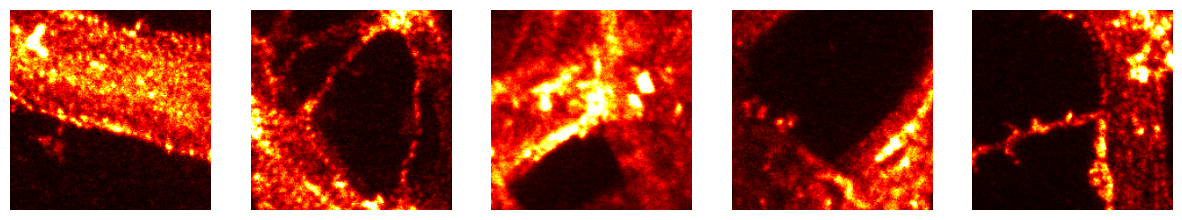

In [80]:
fig, axes = pyplot.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    random_idx = random.randint(0, len(dataset))
    img, info = dataset[random_idx]
    img = img.cpu().data.numpy()
    ax.imshow(img[0], vmin=numpy.quantile(img[0], 0.), vmax=numpy.quantile(img[0], 0.995), cmap="hot")
    ax.axis("off")
pyplot.show()

# KNN

In [81]:
out = defaultdict(list)
for x, label in tqdm(dataloader):
    
    x = x.to(DEVICE)
    features = model.backbone(x).flatten(start_dim=1)
    for key, values in label.items():
        if isinstance(values, torch.Tensor):
            out[key].extend(values.cpu().data.numpy().tolist())
        else:
            out[key].extend(values)
    out["features"].extend(features.cpu().data.numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:27<00:00, 17.35it/s]


Accuracy: 56.14
Accuracy (Block): 67.26
Accuracy (0Mg): 64.92
Accuracy (KCl): 66.42
Accuracy (Glu-Gly): 65.07


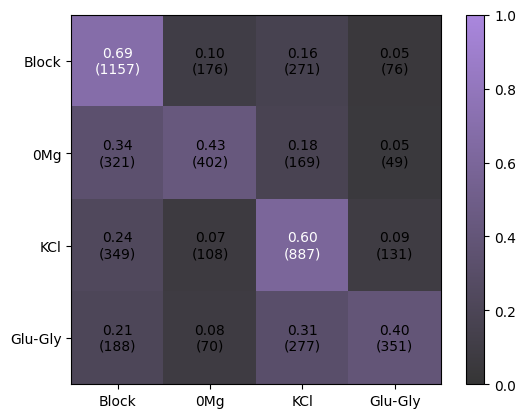

In [82]:
from sklearn.neighbors import NearestNeighbors
SHOW_MISSED = False

samples = numpy.array(out["features"])
labels = numpy.array(out["label"])
indices = numpy.array(out["dataset-idx"])

neigh = NearestNeighbors(n_neighbors=6, metric="minkowski", p=2)
neigh.fit(samples)

# 1st nn is itself
neighbors = neigh.kneighbors(samples, return_distance=False)[:, 1:]
associated_labels = labels[neighbors]

# accuracy = numpy.sum(associated_labels == labels[:, numpy.newaxis], axis=-1)
uniques = numpy.unique(labels)
confusion_matrix = numpy.zeros((len(uniques), len(uniques)))
for unique in uniques:
    mask = labels == unique
    for predicted_unique in uniques:
        votes = numpy.sum((associated_labels[mask] == predicted_unique).astype(int), axis=-1)
        confusion_matrix[unique, predicted_unique] += numpy.sum(votes >= 3)
        if SHOW_MISSED and (unique != predicted_unique) and (numpy.sum(votes >= 3) > 0):
            print(unique, predicted_unique)
            for idx, associated in zip(indices[mask][votes >= 3], associated_labels[mask][votes >= 3]):
                img, metadata = dataset[idx]
                img = img[0].cpu().data.numpy()
                
                fig, ax = pyplot.subplots(figsize=(3,3))
                ax.imshow(img, cmap="hot", vmin=numpy.quantile(img, 0), vmax=numpy.quantile(img, 0.995))
                ax.set_title(associated)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                pyplot.show()
                
def accuracy_per_class(confusion_matrix):
    diag = numpy.diag(confusion_matrix)
    confusion_matrices = {}
    for i in range(len(diag)):
        indices = numpy.setdiff1d(numpy.arange(len(diag)), [i])
        cm = numpy.zeros((2, 2))
        cm[0, 0] = diag[i]
        cm[0, 1] = numpy.sum(confusion_matrix[i, indices])
        cm[1, 1] = numpy.sum(diag[indices])
        cm[1, 0] = numpy.sum(confusion_matrix[indices, i])        
        confusion_matrices[i] = cm
    return confusion_matrices
                
accuracy = numpy.diag(confusion_matrix).sum() / numpy.sum(confusion_matrix)
print(f"Accuracy: {accuracy * 100:0.2f}")
confusion_matrices = accuracy_per_class(confusion_matrix)
for key, cm in confusion_matrices.items():
    tp, tn, fp, fn = cm[0, 0], cm[1, 1], cm[1, 0], cm[0, 1]
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    print(f"Accuracy ({dataset.classes[key]}): {balanced_accuracy * 100:0.2f}")

fig, ax = pyplot.subplots()
cm = confusion_matrix / numpy.sum(confusion_matrix, axis=-1)[:, numpy.newaxis]
im = ax.imshow(cm, vmin=0, vmax=1, cmap="gray-purple")
for j in range(cm.shape[-2]):
    for i in range(cm.shape[-1]):
        ax.annotate(
            f"{cm[j, i]:0.2f}\n({confusion_matrix[j, i]:0.0f})", (i, j), 
            horizontalalignment="center", verticalalignment="center",
            color="white" if cm[j, i] > 0.5 else "black"
        )
ax.set(
    xticks=uniques, yticks=uniques,
    xticklabels=dataset.classes,
    yticklabels=dataset.classes
)
pyplot.colorbar(im, ax=ax)
# savefig(fig, ax, f"./panels/{MODEL}/knn-classification-{DATASET}", save_white=True)
pyplot.show()


In [64]:
numpy.mean(numpy.array([96.49, 91.67, 94.37, 97.81]) - numpy.array([85.55, 75, 81.57, 96.40]))

10.455000000000002

In [84]:
import random
for _ in range(20):
    print(random.choice([3, 6, 12]))

12
6
6
12
6
3
12
3
3
6
12
3
3
12
3
3
3
12
12
6
